In [2]:
import pandas as pd 
import numpy as np 
import re
import more_itertools as mit

# load data into python
file="AIS-data-sample-20190101.xlsx"
file1="AIS_2019_01_01.csv"
df=pd.read_excel(file)
df1=pd.read_csv(file1)
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
0,338208626,2019-01-01T00:00:05,37.86505,-122.31405,0.0,-165.0,511,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,B
1,367420490,2019-01-01T00:00:04,31.26095,-91.65160,4.5,15.0,31,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,B
2,338060122,2019-01-01T00:00:04,30.67109,-81.46722,1.9,-67.4,511,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,B
3,368018190,2019-01-01T00:00:04,30.70736,-88.04332,0.0,-103.6,301,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,B
4,368039230,2019-01-01T00:00:04,35.08305,-90.14214,0.0,-182.3,4,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,B


In [3]:
import re
# Time transformation
def convert(time):
    time_string=str(time)
    lst=list(mit.locate(time_string, lambda x: x==":"))
    a,b=lst[0],lst[1]
    hour=int(time_string[a-2:a])*60*60
    minute=int(time_string[a+1:b])*60
    sec=int(time_string[b+1:b+3])
    converted_time=hour+minute+sec
    return converted_time
lst=[]
for time in df["BaseDateTime"]: 
    converted_time=convert(time)
    lst.append(converted_time)
df['BaseDateTime']=lst

In [65]:
#EDA on NA values
x=df.iloc[2,8]
df.tail(10)
def NA_portion(list):
    rate=0
    for i in list:
        if pd.isna(i)== False:
            continue
        else:
            rate+=1
    total=len(list)
    return rate/total
NA_portion(df['VesselType'])
lst=[]
for col in list(df.columns):
    rate=NA_portion(df[col])
    lst.append(rate)
pd.DataFrame(lst,index=list(df.columns),columns=['NA rate'])

,NA rate
MMSI,0.0000
BaseDateTime,0.0000
LAT,0.0000
LON,0.0000
SOG,0.0000
COG,0.0000
Heading,0.0000
VesselName,0.0496
IMO,0.5854
CallSign,0.1024


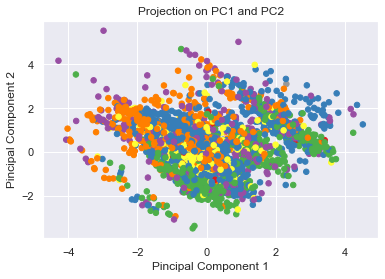

In [108]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#Standardization 
features=df[['BaseDateTime','LAT','LON','SOG','COG','Heading']]# exclude 10% NA rate variable 
x=StandardScaler().fit_transform(features)
x=pd.DataFrame(x,columns=['BaseDateTime','LAT','LON','SOG','COG','Heading'])

#PCA
pca=PCA(n_components=5)
pca.fit(x)

# Visulization on 2-D PC
principleComponents=pca.fit_transform(x)
principalDf=pd.DataFrame(data=principleComponents[:,0:2],columns=['PC1','PC2'])
finalDf = pd.concat([principalDf, df[['VesselType']]], axis = 1)
n_classes = len(np.unique(df['VesselType']))
plt.scatter(principalDf['PC1'],
           principalDf['PC2'],c=df['VesselType'],s=30,cmap='Set1')
plt.title('Projection on PC1 and PC2')
plt.xlabel('Pincipal Component 1')
plt.ylabel('Pincipal Component 2')
plt.show()

[0.23650981 0.21775648 0.16793335 0.14367528 0.13079301]


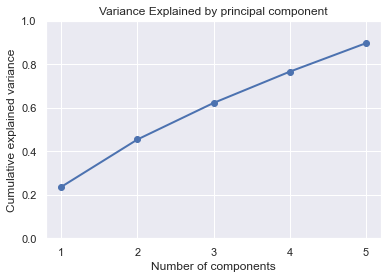

In [115]:
print(pca.explained_variance_ratio_)
# plot for Cumulative explained variance
plt.plot(np.arange(5)+1,np.cumsum(pca.explained_variance_ratio_),'bo-',linewidth=2)
plt.title('Variance Explained by principal component')
plt.xlabel('Number of components')
plt.ylim(0,1)
plt.xticks(np.arange(5)+1)
plt.ylabel('Cumulative explained variance')
plt.show()
# With roughly the same equal variance, 
# We probably shall take all of the the variables into our model